In [1]:
# モジュールのインポート
from matplotlib import pyplot
from matplotlib import patches
import random
import numpy as np
import array

from itertools import repeat
from collections.abc import Sequence
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
%matplotlib inline

In [11]:
# roomというclassを作る
class Room():
    def __init__(self,n,s,fre_move,w=0,l=0,x=0,ud=0):
        self.n = n
        self.s = s
        self.m = m
        self.x = x
        self.ud = ud
        self.w = w
        self.l = l
        
    def distance(self,b):
        return (abs( self.x - b.x )+ abs( self.ud - b.ud )) * self.m[b.n]
    def construction(self):
        S = self.w * self.l
        wall = (self.w + self.l)*2
        return S * 1 + wall * 2
    def penalty(self):
        return abs(self.w * self.l - self.s)

In [3]:
# 遺伝子を生成
def room_gene():
    seq = np.array([random.sample(range(0,8),8)]).T
    ud = np.array([[random.randint(0,1) for i in range(8)]]).T
    wl = np.array([[random.randint(1,10) for i in range(16)]]).reshape(2,8).T
    sp = np.array([random.randint(0,10),random.randint(0,10)])
    gene = np.hstack((seq, ud, wl)).flatten()
    gene = np.insert(gene, 0, sp)
    return gene

In [32]:
# 評価関数
def Eval(individual):
    start_point = individual[0:2]
    ind = np.delete(individual, [0,1]).reshape(8,4)
    seq = ind[:,0:1].flatten()
    
    global Rooms
    for room in Rooms:
        n = room.n
        room.ud = ind[n][1]
        room.w = ind[n][2]
        room.l = ind[n][3]
        
    seq_rooms = [i for _, i in sorted(zip(seq, Rooms))]
    u,d = [],[]
    for seq_room in seq_rooms:
        if seq_room.ud == 0:
            left_point = start_point[0]+sum(u)
            seq_room.x = left_point+seq_room.w/2
            u.append(seq_room.w)
        else:
            left_point = start_point[1]+sum(d)
            seq_room.x = left_point+seq_room.w/2
            d.append(seq_room.w)
    distance_cost = []
    construction_cost = []
    penalty_sum = []
    for room in Rooms:
        distance_cost.append(sum([room.distance(i) for i in Rooms])**2)
        construction_cost.append(room.construction()**2)
        penalty_sum.append(room.penalty()**2)
    dis_c = sum(distance_cost)
    con_c = sum(construction_cost)
    pen_c = sum(penalty_sum)
    a1,a2,a3 = 1,1,1
    return dis_c*a1+con_c*a2+pen_c*a3,

In [24]:
# 交叉
def CX(ind1, ind2, indpb=0.05):
    sp1,sp2 = ind1[0:2],ind2[0:2]
    ind1_ = np.delete(ind1, [0,1]).reshape(8,4)
    ind2_ = np.delete(ind2, [0,1]).reshape(8,4)

    ## cxTwoPoint
    size = min(len(ind1_), len(ind2_))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1_[cxpoint1:cxpoint2], ind2_[cxpoint1:cxpoint2] \
        = ind2_[cxpoint1:cxpoint2], ind1_[cxpoint1:cxpoint2]
    
    sp1[0],sp2[1] = sp2[0],sp1[1]
    
    ind1 = ind1.flatten()
    ind1 = np.insert(ind1, 0, sp1)
    ind2 = ind2.flatten()
    ind2 = np.insert(ind2, 0, sp2)
    return ind1, ind2

In [25]:
# 突然変異
def MUT(individual, low, up, indpb):
    sp = individual[0:2]
    ind = np.delete(individual, [0,1]).reshape(8,4)
    
    sp = np.array([random.randint(0,10),random.randint(0,10)])
    
    # mutswapIndexes
    
    size = len(ind)
    swpoint1 = random.randint(0, size - 1)
    swpoint2 = random.randint(0, size - 2)
    if swpoint2 >= swpoint1:
        swpoint2 += 1
    else:
        swpoint1, swpoint2 = swpoint2, swpoint1
    ind_ = np.insert(ind, swpoint1, ind[swpoint2], axis=0)
    ind_ = np.delete(ind_,swpoint1+1,axis=0)
    ind_ = np.insert(ind_, swpoint2, ind[swpoint1], axis=0)
    ind_ = np.delete(ind_,swpoint2+1,axis=0)
    """
    cgpoint = random.randint(0,size - 1)
    ind_1 = np.hstack((ind[cgpoint][0:2],[random.randint(0,1)],[random.randint(1,10)],[random.randint(1,10)] ))

    ind_ = np.insert(ind, cgpoint, ind_1, axis=0)
    ind_ = np.delete(ind_,cgpoint+1,axis=0)
    """
    
    ind = ind_.flatten()
    individual = np.insert(ind, 0, sp)
    return individual,

In [26]:
# 定義
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 初期条件を構築
toolbox.register("individual", tools.initIterate, creator.Individual, room_gene)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 評価関数、交差、突然変異、選択淘汰
toolbox.register("evaluate", Eval)
toolbox.register("mate", CX, indpb=0.5)
toolbox.register("mutate", MUT,low=1,up=10, indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=5)

In [27]:
def conf(best_ind):
    start_point = best_ind[0:2]
    ind = np.delete(best_ind, [0,1]).reshape(8,4)
    seq = ind[:,0].flatten()
    
    global Rooms
    for room in Rooms:
        n = room.n
        room.ud = ind[n][1]
        room.w = ind[n][2]
        room.l = ind[n][3]
        
    seq_rooms = [i for _, i in sorted(zip(seq, Rooms))]
    u,d = [],[]
    for seq_room in seq_rooms:
        if seq_room.ud == 0:
            left_point = start_point[0]+sum(u)
            seq_room.x = left_point+seq_room.w/2
            u.append(seq_room.w)
        else:
            left_point = start_point[1]+sum(d)
            seq_room.x = left_point+seq_room.w/2
            d.append(seq_room.w)
    fig, ax = pyplot.subplots()

    ax.set_xlim([0,21])
    ax.set_ylim([-11,11])
    ax.grid()
    ax.add_patch(patches.Rectangle( xy=(0,-10.5) ,facecolor="white",edgecolor="black", width=20, height=21))

    for room in Rooms:
        if room.ud == 0:
            ud = 1
        else:
            ud = -1*room.l
        r = patches.Rectangle( xy=(room.x-room.w/2,ud) ,facecolor="white",edgecolor="red", width=room.w, height=room.l) 
        ax.add_patch(r)
    ax.add_patch(patches.Rectangle( xy=(0,0) ,facecolor="white",edgecolor="black", width=20, height=1))

    pyplot.axis('off')
    pyplot.show()

In [28]:
def main():
    pop = toolbox.population(n=1000)
    CXPB, MUTPB ,NGEN = 1, 1, 50
    print("Start of evolution")

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    fits = [ind.fitness.values[0] for ind in pop]
    log_min = [min(fits)]
    log_max = [max(fits)]
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    log_mean = [mean]
    log_std = [std]
    
    print("  Evaluated %i individuals" % len(pop))
    print("gen   nevals      avg      std      min     max" )
    
    for g in range(NGEN):
        
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        pop[:] = offspring

        fits = [ind.fitness.values[0] for ind in pop]
        
        # 母集団の最小、最大、平均、標準偏差を表示
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        log_min.append(min(fits))
        log_max.append(max(fits))
        log_mean.append(mean)
        log_std.append(std)
        gen = list(range(0, NGEN+1))

        print('%2d　　  %4d　  %5d　　%5d　　%5d　 %5d' % (g,len(invalid_ind),mean,std,min(fits),max(fits)))
    print("-- End of (successful) evolution --")
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind, gen, log_min, log_max, log_mean, log_std

Start of evolution
  Evaluated 1000 individuals
gen   nevals      avg      std      min     max
 0　　  1000　   2562　　 1426　　  340　  8215
 1　　  1000　   1098　　  579　　  340　  3576
 2　　  1000　    529　　  181　　  340　  1365
 3　　  1000　    375　　   47　　  340　   634
 4　　  1000　    341　　    7　　  340　   405
 5　　  1000　    340　　    0　　  340　   340
 6　　  1000　    340　　    0　　  340　   340
 7　　  1000　    340　　    0　　  340　   340
 8　　  1000　    340　　    0　　  340　   340
 9　　  1000　    340　　    0　　  340　   340
10　　  1000　    340　　    0　　  340　   340
11　　  1000　    340　　    0　　  340　   340
12　　  1000　    340　　    0　　  340　   340
13　　  1000　    340　　    0　　  340　   340
14　　  1000　    340　　    0　　  340　   340
15　　  1000　    340　　    0　　  340　   340
16　　  1000　    340　　    0　　  340　   340
17　　  1000　    340　　    0　　  340　   340
18　　  1000　    340　　    0　　  340　   340
19　　  1000　    340　　    0　　  340　   340
20　　  1000　    340　　    0　　  340　   340
21　　  1000　    340　　    0　　  340　   340
22　　  1000　    340　　    

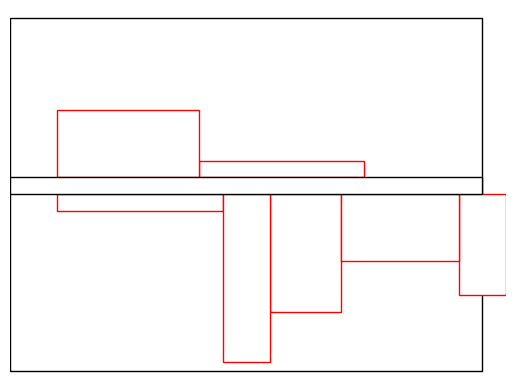

In [33]:
# 設定（部屋番号,部屋の面積,部屋と部屋の間の移動コスト）
Room_1 = Room(0,15,[0,1,1,1,1,1,1,1])
Room_2 = Room(1,15,[1,0,1,1,1,1,1,1])
Room_3 = Room(2,15,[1,1,0,1,1,1,1,1])
Room_4 = Room(3,15,[1,1,1,0,1,1,1,1])
Room_5 = Room(4,15,[1,1,1,1,0,1,1,1])
Room_6 = Room(5,15,[1,1,1,1,1,0,1,1])
Room_7 = Room(6,15,[1,1,1,1,1,1,0,1])
Room_8 = Room(7,15,[1,1,1,1,1,1,1,0])
Rooms = [Room_1,Room_2,Room_3,Room_4,Room_5,Room_6,Room_7,Room_8]

# 実行
if __name__ == "__main__":
    best_ind, gen, log_min, log_max, log_mean, log_std = main()
Best = [0, 1, 2, 3, 4, 5, 6, 7, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1]
conf(best_ind)